### Neuron Model
**The microcircuits of striatum in silico**

### Network List

- SPN (done)
- FS (in-progress)


In [5]:
pip install neuron

Note: you may need to restart the kernel to use updated packages.


In [1]:
### Library
from brian2 import *
import brian2 as br
from brian2tools import *
import matplotlib.pyplot as pltㅋ
import random
import numpy as np
from brian2.units import *
from neuron import h, gui
from brian2 import ms, mV, pA, pF, siemens, amp, second, NeuronGroup, defaultclock, run
import json
import numpy as np

pS = siemens * 1e-12

--No graphics will be displayed.


### Model 1: Quadratic Integrate and Fire (SPN)

- construct dSPN, iSPN
- V: membrane potential 
- u: neuron's slow current
- I<sub>spon</sub>: 뉴런 내부의 활동 반영 (represents the intrinsic spontaneous current with the neuron)
- I<sub>stim</sub>: externally applied stimulus current, which in this context would include the cortical input
- I<sub>syn</sub>: This current arises from synaptic inputs received by the neuron from other neurons within the network (include GABAergic inputs, Glutamatergic inputs)

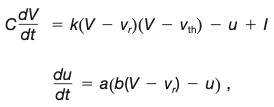

In [4]:
### SPN Neuron Model 
# D1(SD1) - dSPN, D2 - iSPN
# Fountas, Zafeirios. "Action selection in the rhythmic brain: The role of the basal ganglia and tremor." PhD Thesis, Imperial College London (2016).

def Neuron_dSPN():

    eqs = '''
    dv/dt = (K*1*pF/ms/mV*(v-VR)*(v-vt)-u*pF+I)/C + sigma_msn*xi/ms**.5 : volt
    du/dt = a*(b*(v-VR)-u) : volt/second
    VR = vr*(1+KAPA*Dop1) : volt
    K = k*(1-ALPHA*Dop2) : 1
    a       : 1/second
    b       : 1/second
    c       : volt
    d       : volt/second
    k       : 1
    vr      : volt
    vt      : volt
    vpeak   : volt
    I = Ispon + Istim + Isyn : amp
    Istim   : amp
    Ispon   : amp
    Isyn : amp
    Dop1      : 1
    Dop2      : 1
    C : farad  # Capacitance
    '''
    
    params = {
    'a': 0.01 / br.ms,
    'b': -20 / br.ms,
    'c': -55 * br.mV,
    'd': 91 * br.mV / br.ms,
    'vpeak': 4 * br.mV,
    'vr': -80 * br.mV,
    'vt': -29.7 * br.mV,
    'C': 15.2 * br.pF,
    'v': -80 * br.mV,
    'u': 0.0 * br.mV / br.ms,
    'Ispon': 0.0 * br.mV,
    'K': 0.0289,
    'L': 0.331,
    'KAPA': 0.0289,   # Humphries et al. 2009a
    'ALPHA': 0.032,   # Humphries et al. 2009a
    'HTA': 0.1,       # Humphries 2014
    'EPSILON': 0.625, # Humphries 2014
    'BITA1': 0.5,     # Humphries 2014
    'BITA2': 0.3      # Humphries 2014
    }
    
    return eqs, params

In [6]:
def Neuron_iSPN():
    eqs = '''
    dv/dt = (K*1*pF/ms/mV*(v-VR)*(v-vt)-u*pF+I)/C : volt
    du/dt = a*(b*(v-VR)-u) : volt/second
    VR = vr*(1+KAPA*Dop2) : volt
    K = k*(1-ALPHA*Dop1) : 1
    a       : 1/second
    b       : 1/second
    c       : volt
    d       : volt/second
    k       : 1
    vr      : volt
    vt      : volt
    vpeak   : volt
    I = Ispon + Istim + Isyn : amp
    Istim   : amp
    Ispon   : amp
    Isyn    : amp
    Dop1    : 1
    Dop2    : 1
    C : farad  # Capacitance
    '''

    params = {
    'a': 0.01 / br.ms,
    'b': -20 / br.ms,
    'c': -55 * br.mV,
    'd': 91 * br.mV / br.ms,
    'vpeak': 4 * br.mV,
    'vr': -80 * br.mV,
    'vt': -29.7 * br.mV,
    'C': 15.2 * br.pF,
    'v': -80 * br.mV,
    'u': 0.0 * br.mV,
    'Ispon': 0.0 * br.mV,
    'K': 0.0289,
    'L': 0.331,
    'KAPA': 0.0289,   # Humphries et al. 2009a
    'ALPHA': 0.032,   # Humphries et al. 2009a
    'HTA': 0.1,       # Humphries 2014
    'EPSILON': 0.625, # Humphries 2014
    'BITA1': 0.5,     # Humphries 2014
    'BITA2': 0.3      # Humphries 2014
    }
# not consider sigma_msn
    
    return eqs, params

### Model 2: Quadratic Integrate and Fire (FS)

In [39]:
# parameters

sigma_fsi = 4.6*mV 

a = 0.2 / br.ms
b = -0.025 / br.ms
c = -60 / br.mV
d = 0.0 * br.mV / br.ms
vpeak = 25 * br.mV
vr = -70 * mV
vt = -50 * br.mV
C = 80.0 * br.pF 
v = -70 * br.mV
u = 0.0 * br.mV
Ispon = 0.0 * br.mV
k = 1.0
L = 0.331
vb = -55.0 * br.mV
hta = 0.1
epsilon = 0.625 * br.mV

KAPA = 0.0289   # Humphries etal 2009a
ALPHA = 0.032   # Humphries etal 2009a
HTA = 0.1       # Humphries 2014
EPSILON = 0.625 # Humphries 2014
BITA1 = 0.5     # Humphries 2014
BITA2 = 0.3     # Humphries 2014

In [8]:
def Neuron_FS():

    eqs = '''
    dv/dt = (K*1*pF/ms/mV*(v-VR)*(v-vt)-u*pF+I)/C + sigma_msn*xi/ms**.5 : volt
    du/dt = a*(b*(v-VR)-u) : volt/second
    VR = vr*(1+KAPA*Dop1) : volt
    K = k*(1-ALPHA*Dop2) : 1
    a       : 1/second
    b       : 1/second
    c       : volt
    d       : volt/second
    k       : 1
    vr      : volt
    vt      : volt
    C       : pF
    vpeak   : volt
    I = Ispon + Istim + Isyn : amp
    Istim   : amp
    Ispon   : amp
    Isyn = Igaba_MSN + Igaba_FSI + Iampa*(1.0 - BITA2*Dop2) + Inmda*(1.0 + BITA1*Dop1): amp
    Dop1      : 1
    Dop2      : 1
    '''
# not consider sigma_msn
    params = {
        'a': 0.2 / br.ms,
        'b': -0.025 / br.ms,
        'c': -60 * br.mV,
        'd': 0.0 * br.mV / br.ms,
        'vpeak': 25 * br.mV,
        'vr': -70 * br.mV,
        'vt': -50 * br.mV,
        'C': 80.0 * br.pF,
        'v': -70 * br.mV,
        'u': 0.0 * br.mV,
        'Ispon': 0.0 * br.mV,
        'k': 1.0,
        'L': 0.331,
        'vb': -55.0 * br.mV,
        'hta': 0.1,
        'epsilon': 0.625 * br.mV,
        'KAPA': 0.0289,   # Humphries et al. 2009a
        'ALPHA': 0.032,   # Humphries et al. 2009a
        'HTA': 0.1,       # Humphries 2014
        'EPSILON': 0.625, # Humphries 2014
        'BITA1': 0.5,     # Humphries 2014
        'BITA2': 0.3      # Humphries 2014
    }
    
    return eqs, params

### Connect Synapse

In [41]:
### Load synaptic parameter
data = dict()
data["MSN"] = dict()
data["MSN"]["tau"] = {
    "AMPA" :   { "value" : 6 * ms, "unit" : "ms"},
    "NMDA" :   { "value" : 160 * ms, "unit" : "ms"},
    "GABA" :   { "value" : 4 * ms, "unit" : "ms"}
}
data["MSN"]["E"] = {
    "AMPA" :   { "value" : 0 * mV, "unit" : "mV"},
    "NMDA" :   { "value" : 0 * mV, "unit" : "mV"},
    "GABA" :   { "value" : -60 * mV, "unit" : "mV"},
}
data["MSN"]["G"] = {
    "Ctx-MSN" : {
        "AMPA":   { "value" : 0.6, "unit" : "nS"},
        "NMDA":   { "value" : 0.3, "unit" : "nS"},
        "GABA":   { "value" : 0.0, "unit" : "nS"},
    },
    "MSN-MSN" : {
        "AMPA":   { "value" : 0.0, "unit" : "nS"},
        "NMDA":   { "value" : 0.0, "unit" : "nS"},
        "GABA":   { "value" : 0.75, "unit" : "nS"},
    },
    "FSI-MSN" : {
        "AMPA":   { "value" : 0.0, "unit" : "nS"},
        "NMDA":   { "value" : 0.0, "unit" : "nS"},
        "GABA":   { "value" : 3.75, "unit" : "nS"},
    }
}

In [9]:
connect_probability = {
    'pSP1SP1': 0.26,
    'pSP1SP2': 0.06,
    'pSP2SP1': 0.28,
    'pSP2SP2': 0.36,
    'pFSFS': 0.58,      
}

# respectively distance 100um 
connect_probability_100 = {
    'pSP1SP1': 0.07,
    'pSP1SP2': 0.04,
    'pSP2SP1': 0.23,
    'pSP2SP2': 0.13,
    'pFSFS': 0.58,
    'pFSSP1': 0.89,
    'pFSSP2': 0.67      
}

In [10]:
### Synapse Connection
# Hjorth, JJ Johannes, et al. "The microcircuits of striatum in silico." Proceedings of the National Academy of Sciences 117.17 (2020): 9554-9565.

def connect(source, target, model, p_connect=0.1, pre = ''):
    synapse = Synapses(source, target, model=model, on_pre = pre)
    synapse.connect(p=p_connect)
    return synapse

tau_ampa = 6 * ms / 1000
tau_nmda = 160 * ms / 1000
tau_gaba = 4 * ms / 1000
theta_syn = -50 * mV
E_syn = -80 * mV

syn_eqs_SPN = '''
    B = 1.0/(1.0+(0.28)*exp(-0.062*v/mV)) : 1

    Iampa     = G_ampa*g_ampa*(E_ampa-v): amp
    Inmda     = B*G_nmda*g_nmda*(E_nmda-v) : amp
    Igaba_MSN = G_gaba_MSN*g_gaba_MSN*(E_gaba-v) : amp
    Igaba_FSI = G_gaba_FSI*g_gaba_FSI*(E_gaba-v) : amp

    dg_ampa/dt = -g_ampa/tau_ampa : siemens
    dg_nmda/dt = -g_nmda/tau_nmda : siemens
    dg_gaba_MSN/dt = -g_gaba_MSN/tau_gaba : siemens
    dg_gaba_FSI/dt = -g_gaba_FSI/tau_gaba : siemens

    tau_ampa   : second
    tau_nmda   : second
    tau_gaba   : second
    E_ampa     : volt
    E_nmda     : volt
    E_gaba     : volt
    G_ampa     : 1
    G_nmda     : 1
    G_gaba_MSN : 1
    G_gaba_FSI : 1
    '''

syn_eqs_FS = '''
    B = 1.0/(1.0+(0.28)*exp(-0.062*v/mV)) : 1

    Iampa     = G_ampa*g_ampa*(E_ampa-v): amp
    Inmda     = B*G_nmda*g_nmda*(E_nmda-v) : amp
    Igaba_MSN = G_gaba_MSN*g_gaba_MSN*(E_gaba-v) : amp
    Igaba_FSI = G_gaba_FSI*g_gaba_FSI*(E_gaba-v) : amp

    dg_ampa/dt = -g_ampa/tau_ampa : siemens
    dg_nmda/dt = -g_nmda/tau_nmda : siemens
    dg_gaba_MSN/dt = -g_gaba_MSN/tau_gaba : siemens
    dg_gaba_FSI/dt = -g_gaba_FSI/tau_gaba : siemens

    tau_ampa   : second
    tau_nmda   : second
    tau_gaba   : second
    E_ampa     : volt
    E_nmda     : volt
    E_gaba     : volt
    G_ampa     : 1
    G_nmda     : 1
    G_gaba_MSN : 1
    G_gaba_FSI : 1
    '''

def syn_dSPN_dSPN(model = ''):
    syn_eqs_SPN = model
    p_connect = connect_probability['pSP1SP1']
    return syn_eqs_SPN, "g_gaba_MSN += 0.4 * br.nS", p_connect

def syn_iSPN_dSPN(model = ''):
    syn_eqs_SPN = model 
    p_connect = connect_probability['pSP2SP1']
    return syn_eqs_SPN, "g_gaba_MSN += 1.0 * br.nS", p_connect

def syn_dSPN_iSPN(model = ''):
    syn_eqs_SPN = model 
    p_connect = connect_probability['pSP1SP2']
    return syn_eqs_SPN, "g_gaba_MSN += 1.2 * br.nS", p_connect

def syn_iSPN_iSPN(model = ''):
    syn_eqs_SPN = model 
    p_connect = connect_probability['pSP2SP2']
    return syn_eqs_SPN, "g_gaba_MSN += 1.4 * br.nS", p_connect

In [24]:
### Generate Synapse 
# dSPN: D1(SD1), SP1
# iSPN: D2(SD2), SP2
# FS: FS

# 모델 함수 사전
model_functions = {
    'Neuron_dSPN': Neuron_dSPN,
    'Neuron_iSPN': Neuron_iSPN,
    'Neuron_FS': Neuron_FS
}

synapse_functions = {
    'syn_dSPN_dSPN': syn_dSPN_dSPN(syn_eqs_SPN),
    'syn_iSPN_dSPN': syn_iSPN_dSPN(syn_eqs_SPN),
    'syn_dSPN_iSPN': syn_dSPN_iSPN(syn_eqs_SPN),
    'syn_iSPN_iSPN': syn_iSPN_iSPN(syn_eqs_SPN)
}

### Simulation 

In [13]:
### Input value

def generate_cortex_input(duration, dt):
    t = np.arange(0, duration, dt)  # 시간 배열 생성
    input_values = np.ones_like(t) * 20  # 기본 값으로 초기화
    
    spike_time = 50 
    spike_duration = 20
    spike_value = 90

    spike_indices = np.logical_or(t >= spike_time, t < spike_time + spike_duration)
    for i in range(min(spike_time, len(input_values)), min(spike_time + spike_duration, len(input_values))):
        input_values[i] = spike_value
            
    return t * ms, input_values

In [14]:
defaultclock.dt = 1 * ms  # 시뮬레이션 시간 단계 설정
duration = 10000 * ms  # 시뮬레이션 시간 설정
t, cortex_input = generate_cortex_input(duration, defaultclock.dt)

In [29]:
def run_simulation(N, neuron_model_name, target_neuron_model_name, synapse_model_name, duration=1*br.second):
    # 모델 함수 사전에서 선택한 뉴런 및 시냅스 모델과 파라미터를 가져오기
    neuron_model, neuron_params = model_functions[neuron_model_name]()
    t_neuron_model, t_neuron_params = model_functions[target_neuron_model_name]()
    synapse_model, synapse_pre, p_connect = synapse_functions[synapse_model_name]
    print(p_connect)   
    # Define the neuron group
    G = br.NeuronGroup(N, neuron_model, threshold='v > vpeak', reset='v = c; u += d', method='euler')
    T = br.NeuronGroup(N, neuron_model, threshold='v > vpeak', reset='v = c; u += d', method='euler')

    for key, value in neuron_params.items():
        setattr(G, key, value)

    # Define the synapses
    S = connect(G, T, synapse_model, p_connect=0.1, pre=synapse_pre)

    # Run the simulation
    br.run(duration)

    # Plot results
    plt.figure(figsize=(12, 4))
    plt.plot(G.t / br.ms, G.v[0], label='Membrane potential')
    plt.xlabel('Time (ms)')
    plt.ylabel('Voltage (mV)')
    plt.title('Neuron Simulation')
    plt.legend()
    plt.show()


In [32]:
run_simulation(10, 'Neuron_dSPN', 'Neuron_dSPN', 'syn_dSPN_dSPN')

0.26


DimensionMismatchError: Ispon should be set with a value with units amp, but got 0. V (unit is V).